In [1]:
from rdflib import Graph, Namespace, RDF

def ttl_corpora_tags(filename: str) -> list[dict]:
    """
    Parse a Turtle (.ttl) RDF file and extract corpus texts and annotation tags.
    """
    g = Graph()
    g.parse(filename, format="turtle")

    # Define RDF namespaces
    NIF = Namespace("http://persistence.uni-leipzig.org/nlp2rdf/ontologies/nif-core#")
    ITSRDF = Namespace("http://www.w3.org/2005/11/its/rdf#")

    data = []

    for context in g.subjects(RDF.type, NIF.Context):
        entry = {"corpus": None, "tags": []}

        for text in g.objects(context, NIF.isString):
            entry["corpus"] = str(text)

        for span in g.subjects(NIF.referenceContext, context):
            tag = {}

            for anchor in g.objects(span, NIF.anchorOf):
                tag["text"] = str(anchor)
            for begin in g.objects(span, NIF.beginIndex):
                tag["beginIndex"] = int(begin)
            for end in g.objects(span, NIF.endIndex):
                tag["endIndex"] = int(end)
            for ref in g.objects(span, ITSRDF.taIdentRef):
                tag["uri"] = str(ref)

            if tag:
                entry["tags"].append(tag)

        data.append(entry)
    return data

In [2]:
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import json

def eda_file(filename: str):
    """
    Perform exploratory data analysis on a parsed TTL corpus.
    """
    print(f"\n=== EDA for {filename} ===\n{'-'*60}")
    tags = ttl_corpora_tags(filename)
    print(f"The dataset contains {len(tags)} text fragments.\n")

    # Character and word statistics
    char_lens = [len(t["corpus"]) for t in tags if t["corpus"]]
    word_lens = [len(t["corpus"].split()) for t in tags if t["corpus"]]

    print(f"Character count per fragment (avg/min/max): "
          f"{statistics.mean(char_lens):.1f} / {min(char_lens)} / {max(char_lens)}")
    print(f"Word count per fragment (avg/min/max): "
          f"{statistics.mean(word_lens):.1f} / {min(word_lens)} / {max(word_lens)}")

    plt.figure(figsize=(8,4))
    plt.hist(word_lens, bins=30)
    plt.title("Word count distribution per text fragment")
    plt.xlabel("Words per fragment")
    plt.ylabel("Frequency")
    plt.show()

    # Tag statistics
    tag_counts = Counter()
    tag_entity_lens = []
    for t in tags:
        tag_counts += Counter([te.get("uri") for te in t["tags"] if "uri" in te])
        tag_entity_lens.append(len(t["tags"]))

    print(f"\nTagged entities per fragment (avg/min/max): "
          f"{statistics.mean(tag_entity_lens):.1f} / {min(tag_entity_lens)} / {max(tag_entity_lens)}")

    plt.figure(figsize=(8,4))
    plt.hist(tag_entity_lens, bins=30)
    plt.title("Tagged entity count per text fragment")
    plt.xlabel("Entities per fragment")
    plt.ylabel("Frequency")
    plt.show()

    most_common_tags = dict(sorted(tag_counts.items(), key=lambda e: e[1], reverse=True)[:5])
    print(f"Total unique tagged entities: {len(tag_counts)}")
    print(f"5 most commonly tagged entities:\n{json.dumps(most_common_tags, indent=4)}")




=== EDA for ../../data/MSNBC/MSNBCt.ttl ===
------------------------------------------------------------
The dataset contains 1231 text fragments.

Character count per fragment (avg/min/max): 237.3 / 4 / 5208
Word count per fragment (avg/min/max): 39.5 / 1 / 828


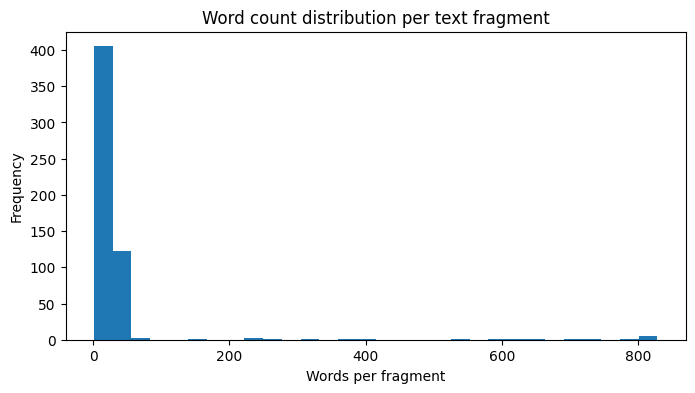


Tagged entities per fragment (avg/min/max): 0.6 / 0 / 14


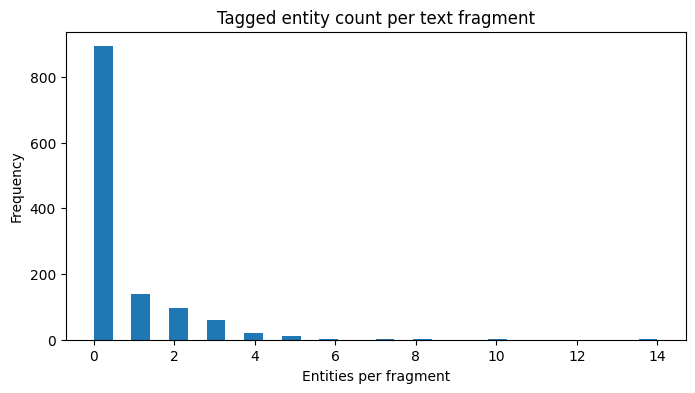

Total unique tagged entities: 328
5 most commonly tagged entities:
{
    "http://en.wikipedia.org/wiki/Gerald_Ford": 25,
    "http://en.wikipedia.org/wiki/Nick_Saban": 25,
    "http://en.wikipedia.org/wiki/Home_Depot": 19,
    "http://en.wikipedia.org/wiki/United_States": 17,
    "http://en.wikipedia.org/wiki/Robert_Nardelli": 16
}





In [3]:
for file in ["../../data/MSNBC/MSNBCt.ttl"]:
    eda_file(file)
    print("\n\n")